In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/CryptoData/

Binance_export.zip  Coinbase_export.zip  OKX_export.zip


In [ ]:
!mkdir -p /content/drive/MyDrive/CryptoData/parquet/Binance
!mkdir -p /content/drive/MyDrive/CryptoData/parquet/Coinbase
!mkdir -p /content/drive/MyDrive/CryptoData/parquet/OKX

In [ ]:
!unzip -o "/content/drive/MyDrive/CryptoData/Binance_export.zip" \
    -d "/content/drive/MyDrive/CryptoData/parquet/Binance"

!unzip -o "/content/drive/MyDrive/CryptoData/Coinbase_export.zip" \
    -d "/content/drive/MyDrive/CryptoData/parquet/Coinbase"

!unzip -o "/content/drive/MyDrive/CryptoData/OKX_export.zip" \
    -d "/content/drive/MyDrive/CryptoData/parquet/OKX"

Archive:  /content/drive/MyDrive/CryptoData/Binance_export.zip
  inflating: /content/drive/MyDrive/CryptoData/parquet/Binance/20250524.parquet  
  inflating: /content/drive/MyDrive/CryptoData/parquet/Binance/20250526.parquet  
  inflating: /content/drive/MyDrive/CryptoData/parquet/Binance/20250525.parquet  
Archive:  /content/drive/MyDrive/CryptoData/Coinbase_export.zip
  inflating: /content/drive/MyDrive/CryptoData/parquet/Coinbase/20250524.parquet  
  inflating: /content/drive/MyDrive/CryptoData/parquet/Coinbase/20250525.parquet  
Archive:  /content/drive/MyDrive/CryptoData/OKX_export.zip
  inflating: /content/drive/MyDrive/CryptoData/parquet/OKX/20250524.parquet  
  inflating: /content/drive/MyDrive/CryptoData/parquet/OKX/20250525.parquet  
  inflating: /content/drive/MyDrive/CryptoData/parquet/OKX/20250526.parquet  


In [ ]:
!find /content/drive/MyDrive/CryptoData/parquet -type f

/content/drive/MyDrive/CryptoData/parquet/Binance/20250524.parquet
/content/drive/MyDrive/CryptoData/parquet/Binance/20250526.parquet
/content/drive/MyDrive/CryptoData/parquet/Binance/20250525.parquet
/content/drive/MyDrive/CryptoData/parquet/Coinbase/20250524.parquet
/content/drive/MyDrive/CryptoData/parquet/Coinbase/20250525.parquet
/content/drive/MyDrive/CryptoData/parquet/OKX/20250524.parquet
/content/drive/MyDrive/CryptoData/parquet/OKX/20250525.parquet
/content/drive/MyDrive/CryptoData/parquet/OKX/20250526.parquet


In [ ]:
cols = con.execute("""
    SELECT *
    FROM read_parquet('/content/drive/MyDrive/CryptoData/parquet/Binance/20250524.parquet')
    LIMIT 1
""").df().columns

print(cols)

Index(['ts', 'rec_type', 'side', 'price', 'qty'], dtype='object')


In [ ]:
import duckdb
import os

con = duckdb.connect()

input_folders = {
    'Binance': '/content/drive/MyDrive/CryptoData/parquet/Binance',
    'Coinbase': '/content/drive/MyDrive/CryptoData/parquet/Coinbase',
    'OKX': '/content/drive/MyDrive/CryptoData/parquet/OKX'
}

output_folder = '/content/drive/MyDrive/CryptoData/1s_bars'
os.makedirs(output_folder, exist_ok=True)

for exchange, folder in input_folders.items():
    files = os.listdir(folder)
    files = [f for f in files if f.endswith('.parquet')]
    for file_name in sorted(files):
        file_path = os.path.join(folder, file_name)
        out_file = os.path.join(output_folder, f'{exchange}_{file_name}')

        print(f'Processing {file_path} → {out_file}')

        con.execute(f"""
        COPY (
            SELECT
                date_trunc('second', ts) AS ts_1s,
                '{exchange}' AS exchange,
                LAST_VALUE(price) OVER (
                    ORDER BY ts
                    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                ) AS last_price,
                SUM(qty) OVER (
                    PARTITION BY date_trunc('second', ts)
                    ORDER BY ts
                    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                ) AS cum_qty
            FROM read_parquet('{file_path}')
            ORDER BY ts_1s
        ) TO '{out_file}' (FORMAT PARQUET)
        """)

        print(f'Finished {file_name}')

Processing /content/drive/MyDrive/CryptoData/parquet/Binance/20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars/Binance_20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250524.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/Binance/20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars/Binance_20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250525.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/Binance/20250526.parquet → /content/drive/MyDrive/CryptoData/1s_bars/Binance_20250526.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250526.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/Coinbase/20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars/Coinbase_20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250524.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/Coinbase/20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars/Coinbase_20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250525.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/OKX/20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars/OKX_20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250524.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/OKX/20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars/OKX_20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250525.parquet
Processing /content/drive/MyDrive/CryptoData/parquet/OKX/20250526.parquet → /content/drive/MyDrive/CryptoData/1s_bars/OKX_20250526.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250526.parquet


In [ ]:
all_1s = duckdb.read_parquet('/content/drive/MyDrive/CryptoData/1s_bars/*.parquet')

In [4]:
import duckdb
import os

con = duckdb.connect()

input_folder = '/content/drive/MyDrive/CryptoData/parquet/Binance'
output_folder = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Binance'
os.makedirs(output_folder, exist_ok=True)

files = sorted([f for f in os.listdir(input_folder) if f.endswith('.parquet')])

for file_name in files:
    file_path = os.path.join(input_folder, file_name)
    out_file = os.path.join(output_folder, f'{file_name}')
    print(f'Processing {file_name} → {out_file}')

    con.execute(f"""
    COPY (
        SELECT
            ts_1s,
            (ARRAY_AGG(price ORDER BY ts))[-1] AS last_price,
            SUM(qty) AS total_qty
        FROM (
            SELECT *,
                   date_trunc('second', ts) AS ts_1s
            FROM read_parquet('{file_path}')
        )
        GROUP BY ts_1s
        ORDER BY ts_1s
    ) TO '{out_file}' (FORMAT PARQUET)
    """)

    print(f'Finished {file_name}')

Processing 20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250524.parquet
Processing 20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250525.parquet
Processing 20250526.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250526.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finished 20250526.parquet


In [5]:
import os

con = duckdb.connect()

agg_folder = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Binance'

files = sorted([f for f in os.listdir(agg_folder) if f.endswith('.parquet')])

for file_name in files:
    file_path = os.path.join(agg_folder, file_name)
    row_count = con.execute(f"SELECT COUNT(*) FROM read_parquet('{file_path}')").fetchone()[0]
    print(f"{file_name}: {row_count} rows")

20250524.parquet: 86400 rows
20250525.parquet: 86400 rows
20250526.parquet: 86400 rows


In [6]:
import duckdb
import os

con = duckdb.connect()

exchanges = ['Binance', 'Coinbase', 'OKX']
input_base = '/content/drive/MyDrive/CryptoData/parquet'
output_base = '/content/drive/MyDrive/CryptoData/1s_bars_agg'

for ex in exchanges:
    input_folder = os.path.join(input_base, ex)
    output_folder = os.path.join(output_base, ex)
    os.makedirs(output_folder, exist_ok=True)

    files = sorted([f for f in os.listdir(input_folder) if f.endswith('.parquet')])

    print(f"\nProcessing {ex} ({len(files)} files)...")

    for file_name in files:
        file_path = os.path.join(input_folder, file_name)
        out_file = os.path.join(output_folder, file_name)
        print(f"  Aggregating {file_name} → {out_file}")

        con.execute(f"""
        COPY (
            SELECT
                ts_1s,
                (ARRAY_AGG(price ORDER BY ts))[-1] AS last_price,
                SUM(qty) AS total_qty
            FROM (
                SELECT *,
                       date_trunc('second', ts) AS ts_1s
                FROM read_parquet('{file_path}')
            )
            GROUP BY ts_1s
            ORDER BY ts_1s
        ) TO '{out_file}' (FORMAT PARQUET)
        """)

        row_count = con.execute(f"SELECT COUNT(*) FROM read_parquet('{out_file}')").fetchone()[0]
        print(f"    Done — {row_count} rows")


Processing Binance (3 files)...
  Aggregating 20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86400 rows
  Aggregating 20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86400 rows
  Aggregating 20250526.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250526.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86400 rows

Processing Coinbase (2 files)...
  Aggregating 20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Coinbase/20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 85595 rows
  Aggregating 20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/Coinbase/20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 85790 rows

Processing OKX (3 files)...
  Aggregating 20250524.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/OKX/20250524.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86400 rows
  Aggregating 20250525.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/OKX/20250525.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86349 rows
  Aggregating 20250526.parquet → /content/drive/MyDrive/CryptoData/1s_bars_agg/OKX/20250526.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    Done — 86400 rows


In [7]:
import pandas as pd

bin_file = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250524.parquet'
coin_file = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Coinbase/20250524.parquet'

df_bin = pd.read_parquet(bin_file)
df_coin = pd.read_parquet(coin_file)

df_bin['ts_1s'] = pd.to_datetime(df_bin['ts_1s'])
df_coin['ts_1s'] = pd.to_datetime(df_coin['ts_1s'])

df = pd.merge(df_bin[['ts_1s', 'last_price']],
              df_coin[['ts_1s', 'last_price']],
              on='ts_1s',
              suffixes=('_bin', '_coin'))

df.head()

,ts_1s,last_price_bin,last_price_coin
0,2025-05-24 00:00:00,2526.16,2525.96
1,2025-05-24 00:00:01,2526.16,2526.30
2,2025-05-24 00:00:02,2526.00,2525.91
3,2025-05-24 00:00:03,2536.69,2527.96
4,2025-05-24 00:00:04,2525.89,2525.91


In [57]:
import pandas as pd

bin_file = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/20250524.parquet'
coin_file = '/content/drive/MyDrive/CryptoData/1s_bars_agg/Coinbase/20250524.parquet'
okx_file  = '/content/drive/MyDrive/CryptoData/1s_bars_agg/OKX/20250524.parquet'

df_bin  = pd.read_parquet(bin_file)
df_coin = pd.read_parquet(coin_file)
df_okx  = pd.read_parquet(okx_file)

df_bin['ts_1s']  = pd.to_datetime(df_bin['ts_1s'])
df_coin['ts_1s'] = pd.to_datetime(df_coin['ts_1s'])
df_okx['ts_1s']  = pd.to_datetime(df_okx['ts_1s'])

df_bin  = df_bin[['ts_1s', 'last_price']].rename(columns={'last_price':'last_price_bin'})
df_coin = df_coin[['ts_1s', 'last_price']].rename(columns={'last_price':'last_price_coin'})
df_okx  = df_okx[['ts_1s', 'last_price']].rename(columns={'last_price':'last_price_okx'})

df = df_bin.merge(df_coin, on='ts_1s', how='inner').merge(df_okx, on='ts_1s', how='inner')

df.head()

,ts_1s,last_price_bin,last_price_coin,last_price_okx
0,2025-05-24 00:00:00,2526.16,2525.96,2532.61
1,2025-05-24 00:00:01,2526.16,2526.30,2516.36
2,2025-05-24 00:00:02,2526.00,2525.91,2526.30
3,2025-05-24 00:00:03,2536.69,2527.96,2532.59
4,2025-05-24 00:00:04,2525.89,2525.91,2526.30


In [95]:
df['last_price_bin']  = df['last_price_bin'].astype(float)
df['last_price_coin'] = df['last_price_coin'].astype(float)
df['last_price_okx']  = df['last_price_okx'].astype(float)

df['spread_A'] = df['last_price_bin'] - df['last_price_coin']
df['spread_B'] = df['last_price_bin'] - df['last_price_okx']
df['spread_C'] = df['last_price_coin'] - df['last_price_okx']

df['ts_1s'] = pd.to_datetime(df['ts_1s'])

half_life_seconds = 3 * 3600  # 3 hours
df['ema_A'] = df['spread_A'].ewm(halflife=pd.Timedelta(seconds=half_life_seconds), times=df['ts_1s']).mean()
df['ema_B'] = df['spread_B'].ewm(halflife=pd.Timedelta(seconds=half_life_seconds), times=df['ts_1s']).mean()
df['ema_C'] = df['spread_C'].ewm(halflife=pd.Timedelta(seconds=half_life_seconds), times=df['ts_1s']).mean()

df['shifted_A'] = (df['spread_A'] - df['ema_A']).clip(-5, 5)
df['shifted_B'] = (df['spread_B'] - df['ema_B']).clip(-5, 5)
df['shifted_C'] = (df['spread_C'] - df['ema_C']).clip(-5, 5)

df[['ts_1s','spread_A','ema_A','shifted_A']].head(10)

,ts_1s,spread_A,ema_A,shifted_A
0,2025-05-24 00:00:00,0.20,0.200000,0.000000
1,2025-05-24 00:00:01,-0.14,0.029995,-0.169995
2,2025-05-24 00:00:02,0.09,0.049998,0.040002
3,2025-05-24 00:00:03,8.73,2.220207,5.000000
4,2025-05-24 00:00:04,-0.02,1.772108,-1.792108
5,2025-05-24 00:00:05,-1.95,1.151657,-3.101657
6,2025-05-24 00:00:06,-0.21,0.957097,-1.167097
7,2025-05-24 00:00:07,0.51,0.901198,-0.391198
8,2025-05-24 00:00:08,-3.18,0.447615,-3.627615
9,2025-05-24 00:00:09,-0.34,0.368831,-0.708831


In [102]:
def compute_persistent_spreads(shifted, N=10, M=10):

    pS = shifted.rolling(M, min_periods=N).apply(lambda x: sorted(x)[N-1], raw=False)
    pL = shifted.rolling(M, min_periods=N).apply(lambda x: sorted(x, reverse=True)[N-1], raw=False)
    return pS, pL

In [103]:
N = 10
M = 10

df['pS_A'], df['pL_A'] = compute_persistent_spreads(df['shifted_A'], N=N, M=M)
df['pS_B'], df['pL_B'] = compute_persistent_spreads(df['shifted_B'], N=N, M=M)
df['pS_C'], df['pL_C'] = compute_persistent_spreads(df['shifted_C'], N=N, M=M)

df[['ts_1s','shifted_A','pS_A','pL_A','shifted_B','pS_B','pL_B']].head(20)


,ts_1s,shifted_A,pS_A,pL_A,shifted_B,pS_B,pL_B
0,2025-05-24 00:00:00,0.000000,NaN,NaN,0.000000,NaN,NaN
1,2025-05-24 00:00:01,-0.169995,NaN,NaN,5.000000,NaN,NaN
2,2025-05-24 00:00:02,0.040002,NaN,NaN,-1.316798,NaN,NaN
3,2025-05-24 00:00:03,5.000000,NaN,NaN,2.312327,NaN,NaN
4,2025-05-24 00:00:04,-1.792108,NaN,NaN,-1.758082,NaN,NaN
5,2025-05-24 00:00:05,-3.101657,NaN,NaN,-1.381691,NaN,NaN
6,2025-05-24 00:00:06,-1.167097,NaN,NaN,-1.278551,NaN,NaN
7,2025-05-24 00:00:07,-0.391198,NaN,NaN,-5.000000,NaN,NaN
8,2025-05-24 00:00:08,-3.627615,NaN,NaN,0.213540,NaN,NaN
9,2025-05-24 00:00:09,-0.708831,5.000000,-3.627615,-0.185808,5.000000,-5.0


In [99]:
g = 1.5
j = 0.5
ell = 20
trade_size = 1
N = 10
M = 10
fee_per_trade = 0.001

df['shifted_A'] = df['shifted_A'].astype(float)
df['pS_A'] = df['pS_A'].astype(float)
df['pL_A'] = df['pL_A'].astype(float)

current_position = 0
entry_price = 0.0
capital = 80000.0
pnl = 0.0
stop_trading = False

trade_rows = []

for i, row in df.iterrows():

    if stop_trading:
        break

    close_trade = False

    if current_position != 0:
        if current_position == 1:
            if (row['pL_A'] > -j) or (row['shifted_A'] < -ell):
                close_trade = True
        elif current_position == -1:
            if (row['pS_A'] < j) or (row['shifted_A'] > ell):
                close_trade = True

        if close_trade:
            if current_position == 1:
                pnl = (row['shifted_A'] - entry_price) * trade_size
            else:
                pnl = (entry_price - row['shifted_A']) * trade_size

            pnl -= 2 * fee_per_trade * trade_size * abs(entry_price)
            capital += pnl

            trade_rows.append({
                'ts_1s': row['ts_1s'],
                'position': 0,
                'pnl': pnl,
                'capital': capital
            })

            if abs(row['shifted_A']) > ell:
                stop_trading = True

            if capital <= 40000.0:
                stop_trading = True

            current_position = 0
            entry_price = 0.0
            pnl = 0.0

    if not stop_trading and current_position == 0:
        if row['pS_A'] > g:
            current_position = -1
            entry_price = row['shifted_A']
            trade_rows.append({
                'ts_1s': row['ts_1s'],
                'position': current_position,
                'pnl': 0.0,
                'capital': capital
            })
        elif row['pL_A'] < -g:
            current_position = 1
            entry_price = row['shifted_A']
            trade_rows.append({
                'ts_1s': row['ts_1s'],
                'position': current_position,
                'pnl': 0.0,
                'capital': capital
            })

trades_df = pd.DataFrame(trade_rows)

if current_position != 0 and not stop_trading:
    last_row = df.iloc[-1]
    if current_position == 1:
        pnl = (last_row['shifted_A'] - entry_price) * trade_size
    else:
        pnl = (entry_price - last_row['shifted_A']) * trade_size
    pnl -= 2 * fee_per_trade * trade_size * abs(entry_price)
    capital += pnl
    trades_df = pd.concat([trades_df, pd.DataFrame([{
        'ts_1s': last_row['ts_1s'],
        'position': 0,
        'pnl': pnl,
        'capital': capital
    }])], ignore_index=True)

trades_df = trades_df.reset_index(drop=True)

trades_df


,ts_1s,position,pnl,capital
0,2025-05-24 00:00:09,-1,0.000000,80000.000000
1,2025-05-24 00:01:15,0,-1.001284,79998.998716
2,2025-05-24 00:01:15,1,0.000000,79998.998716
3,2025-05-24 01:17:00,0,-0.632116,79998.366600
4,2025-05-24 01:17:00,-1,0.000000,79998.366600
5,2025-05-24 01:20:58,0,1.323985,79999.690585
6,2025-05-24 01:20:58,1,0.000000,79999.690585
7,2025-05-24 01:24:03,0,1.454615,80001.145200
8,2025-05-24 01:24:03,-1,0.000000,80001.145200
9,2025-05-24 01:24:09,0,1.315468,80002.460668


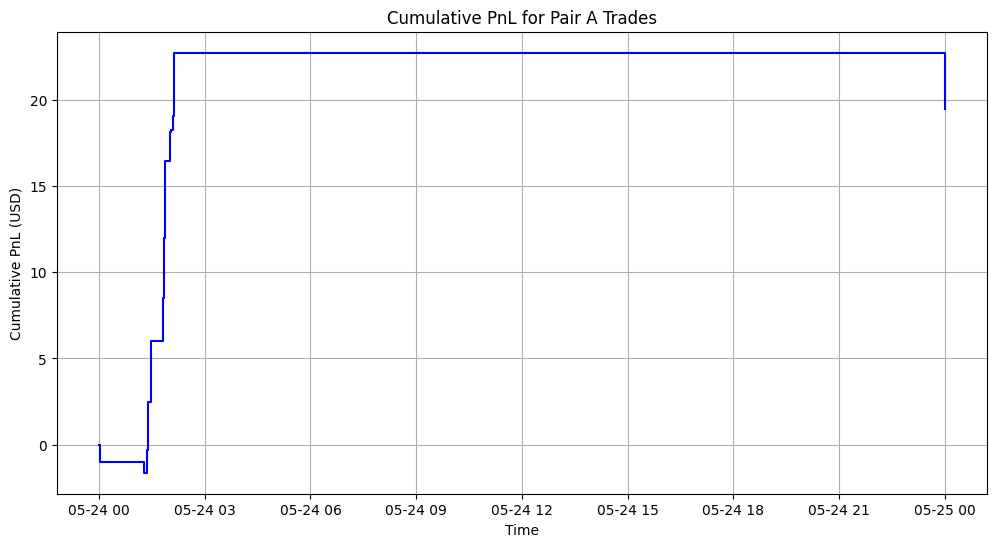

In [100]:
import matplotlib.pyplot as plt

trades_df['cumulative_pnl'] = trades_df['capital'] - 80000

plt.figure(figsize=(12,6))
plt.step(trades_df['ts_1s'], trades_df['cumulative_pnl'], where='post', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL (USD)')
plt.title('Cumulative PnL for Pair A Trades')
plt.grid(True)
plt.show()


Number of trades: 15
Raw return: $19.49
Max drawdown: $3.27
Sharpe ratio (per trade): 2.41


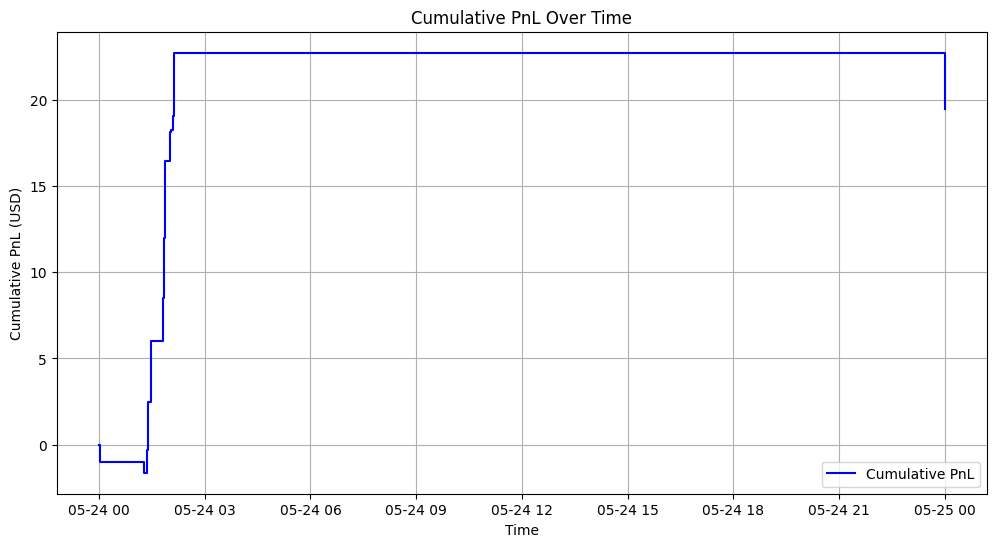

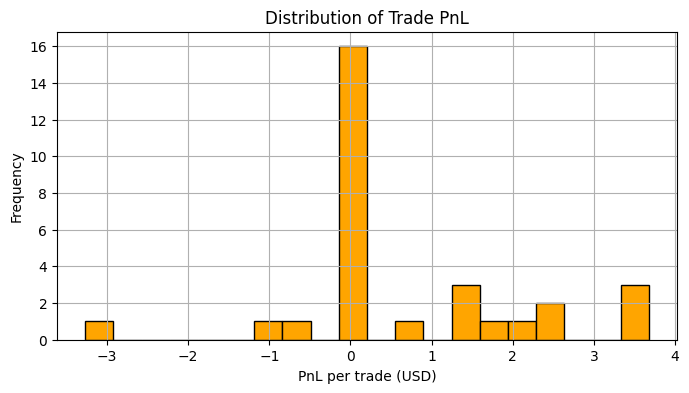

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_trades(trades_df, starting_capital=80000.0):
    if trades_df.empty:
        print("No trades to analyze.")
        return

    trades_df = trades_df.copy()
    trades_df['cumulative_pnl'] = trades_df['capital'] - starting_capital
    trades_df['returns'] = trades_df['cumulative_pnl'].diff().fillna(0)

    mean_return = trades_df['returns'].mean()
    std_return = trades_df['returns'].std()
    sharpe = (mean_return / std_return * np.sqrt(len(trades_df))) if std_return != 0 else np.nan

    cum_max = trades_df['capital'].cummax()
    drawdown = trades_df['capital'] - cum_max
    max_drawdown = drawdown.min()

    raw_return = trades_df['capital'].iloc[-1] - starting_capital

    print(f"Number of trades: {len(trades_df)//2}")
    print(f"Raw return: ${raw_return:,.2f}")
    print(f"Max drawdown: ${abs(max_drawdown):,.2f}")
    print(f"Sharpe ratio (per trade): {sharpe:.2f}")

    plt.figure(figsize=(12,6))
    plt.step(trades_df['ts_1s'], trades_df['cumulative_pnl'], where='post', color='blue', label='Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL (USD)')
    plt.title('Cumulative PnL Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.hist(trades_df['returns'], bins=20, color='orange', edgecolor='black')
    plt.xlabel('PnL per trade (USD)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Trade PnL')
    plt.grid(True)
    plt.show()

analyze_trades(trades_df)

In [105]:
import pandas as pd
import os

days = ['20250524', '20250525', '20250526']

dfs = []

for day in days:
    bin_file  = f'/content/drive/MyDrive/CryptoData/1s_bars_agg/Binance/{day}.parquet'
    coin_file = f'/content/drive/MyDrive/CryptoData/1s_bars_agg/Coinbase/{day}.parquet'
    okx_file  = f'/content/drive/MyDrive/CryptoData/1s_bars_agg/OKX/{day}.parquet'

    if not os.path.exists(coin_file):
        print(f"Skipping {day}: Coinbase file not found")
        continue

    df_bin  = pd.read_parquet(bin_file)
    df_coin = pd.read_parquet(coin_file)
    df_okx  = pd.read_parquet(okx_file)

    for d in [df_bin, df_coin, df_okx]:
        d['ts_1s'] = pd.to_datetime(d['ts_1s'])

    df_bin  = df_bin[['ts_1s','last_price']].rename(columns={'last_price':'last_price_bin'})
    df_coin = df_coin[['ts_1s','last_price']].rename(columns={'last_price':'last_price_coin'})
    df_okx  = df_okx[['ts_1s','last_price']].rename(columns={'last_price':'last_price_okx'})

    df_day = df_bin.merge(df_coin, on='ts_1s', how='inner').merge(df_okx, on='ts_1s', how='inner')

    dfs.append(df_day)

df = pd.concat(dfs).reset_index(drop=True)

df.head(10)


Skipping 20250526: Coinbase file not found


,ts_1s,last_price_bin,last_price_coin,last_price_okx
0,2025-05-24 00:00:00,2526.16,2525.96,2532.61
1,2025-05-24 00:00:01,2526.16,2526.30,2516.36
2,2025-05-24 00:00:02,2526.00,2525.91,2526.30
3,2025-05-24 00:00:03,2536.69,2527.96,2532.59
4,2025-05-24 00:00:04,2525.89,2525.91,2526.30
5,2025-05-24 00:00:05,2525.69,2527.64,2526.00
6,2025-05-24 00:00:06,2525.54,2525.75,2525.96
7,2025-05-24 00:00:07,2525.30,2524.79,2532.35
8,2025-05-24 00:00:08,2525.72,2528.90,2525.61
9,2025-05-24 00:00:09,2525.79,2526.13,2526.10


In [106]:
import pandas as pd

df['last_price_bin']  = df['last_price_bin'].astype(float)
df['last_price_coin'] = df['last_price_coin'].astype(float)
df['last_price_okx']  = df['last_price_okx'].astype(float)

df['spread_A'] = df['last_price_bin'] - df['last_price_coin']
df['spread_B'] = df['last_price_bin'] - df['last_price_okx']
df['spread_C'] = df['last_price_coin'] - df['last_price_okx']

half_life_seconds = 3 * 3600
df['ema_A'] = df['spread_A'].ewm(halflife=half_life_seconds, adjust=False).mean()
df['ema_B'] = df['spread_B'].ewm(halflife=half_life_seconds, adjust=False).mean()
df['ema_C'] = df['spread_C'].ewm(halflife=half_life_seconds, adjust=False).mean()

# Shifted spreads capped at ±5
df['shifted_A'] = (df['spread_A'] - df['ema_A']).clip(-5, 5)
df['shifted_B'] = (df['spread_B'] - df['ema_B']).clip(-5, 5)
df['shifted_C'] = (df['spread_C'] - df['ema_C']).clip(-5, 5)

day3_mask = df['ts_1s'].dt.date == pd.to_datetime('2025-05-26').date()

last_day2_A = df.loc[df['ts_1s'].dt.date == pd.to_datetime('2025-05-25').date(), 'shifted_A'].iloc[-1]
last_day2_C = df.loc[df['ts_1s'].dt.date == pd.to_datetime('2025-05-25').date(), 'shifted_C'].iloc[-1]

df.loc[day3_mask, 'shifted_A'] = last_day2_A
df.loc[day3_mask, 'shifted_C'] = last_day2_C

df[['ts_1s','shifted_A','shifted_B','shifted_C']].head(10)

,ts_1s,shifted_A,shifted_B,shifted_C
0,2025-05-24 00:00:00,0.000000,0.000000,0.000000
1,2025-05-24 00:00:01,-0.339978,5.000000,5.000000
2,2025-05-24 00:00:02,-0.109971,5.000000,5.000000
3,2025-05-24 00:00:03,5.000000,5.000000,2.018404
4,2025-05-24 00:00:04,-0.220504,5.000000,5.000000
5,2025-05-24 00:00:05,-2.150366,5.000000,5.000000
6,2025-05-24 00:00:06,-0.410340,5.000000,5.000000
7,2025-05-24 00:00:07,0.309640,-0.603244,-0.912884
8,2025-05-24 00:00:08,-3.380143,5.000000,5.000000
9,2025-05-24 00:00:09,-0.540108,5.000000,5.000000


In [107]:
def compute_persistent_spreads(shifted, N=10, M=10):

    pS = shifted.rolling(M, min_periods=N).apply(lambda x: sorted(x)[N-1], raw=False)
    pL = shifted.rolling(M, min_periods=N).apply(lambda x: sorted(x, reverse=True)[N-1], raw=False)
    return pS, pL

In [110]:
N = 10
M = 10

df['pS_A'] = df['shifted_A'].rolling(M).apply(lambda x: sorted(x)[N-1]).fillna(0)
df['pL_A'] = df['shifted_A'].rolling(M).apply(lambda x: sorted(x)[-N]).fillna(0)

df['pS_B'] = df['shifted_B'].rolling(M).apply(lambda x: sorted(x)[N-1]).fillna(0)
df['pL_B'] = df['shifted_B'].rolling(M).apply(lambda x: sorted(x)[-N]).fillna(0)

df['pS_C'] = df['shifted_C'].rolling(M).apply(lambda x: sorted(x)[N-1]).fillna(0)
df['pL_C'] = df['shifted_C'].rolling(M).apply(lambda x: sorted(x)[-N]).fillna(0)

In [111]:
import pandas as pd

g = 1.5
j = 0.5
ell = 20
trade_size = 1
N = 10
M = 10
fee_per_trade = 0.001

for col in ['shifted_A','shifted_B','shifted_C']:
    df[col] = df[col].astype(float)

def compute_pS_pL(series, N, M):
    pS = series.rolling(M).apply(lambda x: sorted(x)[N-1] if len(x) >= N else x[-1]).fillna(0)
    pL = series.rolling(M).apply(lambda x: sorted(x)[-N] if len(x) >= N else x[-1]).fillna(0)
    return pS, pL

df['pS_A'], df['pL_A'] = compute_pS_pL(df['shifted_A'], N, M)
df['pS_B'], df['pL_B'] = compute_pS_pL(df['shifted_B'], N, M)
df['pS_C'], df['pL_C'] = compute_pS_pL(df['shifted_C'], N, M)

def run_trading(spread_col, pS_col, pL_col):
    current_position = 0
    entry_price = 0.0
    capital = 80000.0
    pnl = 0.0
    stop_trading = False

    trade_rows = []

    for i, row in df.iterrows():
        if stop_trading:
            break

        close_trade = False

        if current_position != 0:
            if current_position == 1:  # long
                if (row[pL_col] > -j) or (row[spread_col] < -ell):
                    close_trade = True
            elif current_position == -1:  # short
                if (row[pS_col] < j) or (row[spread_col] > ell):
                    close_trade = True

            if close_trade:
                if current_position == 1:
                    pnl = (row[spread_col] - entry_price) * trade_size
                else:
                    pnl = (entry_price - row[spread_col]) * trade_size

                pnl -= 2 * fee_per_trade * trade_size * abs(entry_price)
                capital += pnl

                trade_rows.append({
                    'ts_1s': row['ts_1s'],
                    'position': 0,
                    'pnl': pnl,
                    'capital': capital
                })

                if abs(row[spread_col]) > ell:
                    stop_trading = True
                if capital <= 40000:
                    stop_trading = True

                current_position = 0
                entry_price = 0.0
                pnl = 0.0

        if not stop_trading and current_position == 0:
            if row[pS_col] > g:
                current_position = -1
                entry_price = row[spread_col]
                trade_rows.append({
                    'ts_1s': row['ts_1s'],
                    'position': current_position,
                    'pnl': 0.0,
                    'capital': capital
                })
            elif row[pL_col] < -g:
                current_position = 1
                entry_price = row[spread_col]
                trade_rows.append({
                    'ts_1s': row['ts_1s'],
                    'position': current_position,
                    'pnl': 0.0,
                    'capital': capital
                })

    if current_position != 0 and not stop_trading:
        last_row = df.iloc[-1]
        if current_position == 1:
            pnl = (last_row[spread_col] - entry_price) * trade_size
        else:
            pnl = (entry_price - last_row[spread_col]) * trade_size
        pnl -= 2 * fee_per_trade * trade_size * abs(entry_price)
        capital += pnl
        trade_rows.append({
            'ts_1s': last_row['ts_1s'],
            'position': 0,
            'pnl': pnl,
            'capital': capital
        })

    return pd.DataFrame(trade_rows).reset_index(drop=True)

trades_A = run_trading('shifted_A', 'pS_A', 'pL_A')
trades_B = run_trading('shifted_B', 'pS_B', 'pL_B')
trades_C = run_trading('shifted_C', 'pS_C', 'pL_C')

all_trades = {
    'A': trades_A,
    'B': trades_B,
    'C': trades_C
}


,ts_1s,position,pnl,capital
0,2025-05-24 00:00:09,-1,0.000000,80000.000000
1,2025-05-24 00:01:15,0,-0.890902,79999.109098
2,2025-05-24 00:01:15,1,0.000000,79999.109098
3,2025-05-24 00:07:33,0,-0.821284,79998.287815
4,2025-05-24 00:07:35,1,0.000000,79998.287815


In [112]:
for name, df_trades in all_trades.items():
    print(f"Top 10 rows of trades_{name}:")
    print(df_trades.head(10))
    print("\n" + "="*50 + "\n")

Top 10 rows of trades_A:
                ts_1s  position       pnl       capital
0 2025-05-24 00:00:09        -1  0.000000  80000.000000
1 2025-05-24 00:01:15         0 -0.890902  79999.109098
2 2025-05-24 00:01:15         1  0.000000  79999.109098
3 2025-05-24 00:07:33         0 -0.821284  79998.287815
4 2025-05-24 00:07:35         1  0.000000  79998.287815
5 2025-05-24 00:08:20         0  1.665948  79999.953763
6 2025-05-24 00:08:20        -1  0.000000  79999.953763
7 2025-05-24 00:08:54         0  0.730642  80000.684406
8 2025-05-24 00:08:54         1  0.000000  80000.684406
9 2025-05-24 00:15:36         0  2.134819  80002.819225


Top 10 rows of trades_B:
                ts_1s  position       pnl       capital
0 2025-05-24 00:00:09        -1  0.000000  80000.000000
1 2025-05-25 05:29:05         0  6.957794  80006.957794
2 2025-05-25 05:29:05         1  0.000000  80006.957794
3 2025-05-25 05:31:27         0  6.963858  80013.921653
4 2025-05-25 05:31:27        -1  0.000000  80013.921

--- Pair A ---
Number of trades: 42
Raw return: $128.11
Max drawdown: $1.71
Sharpe ratio (per trade): 6.20




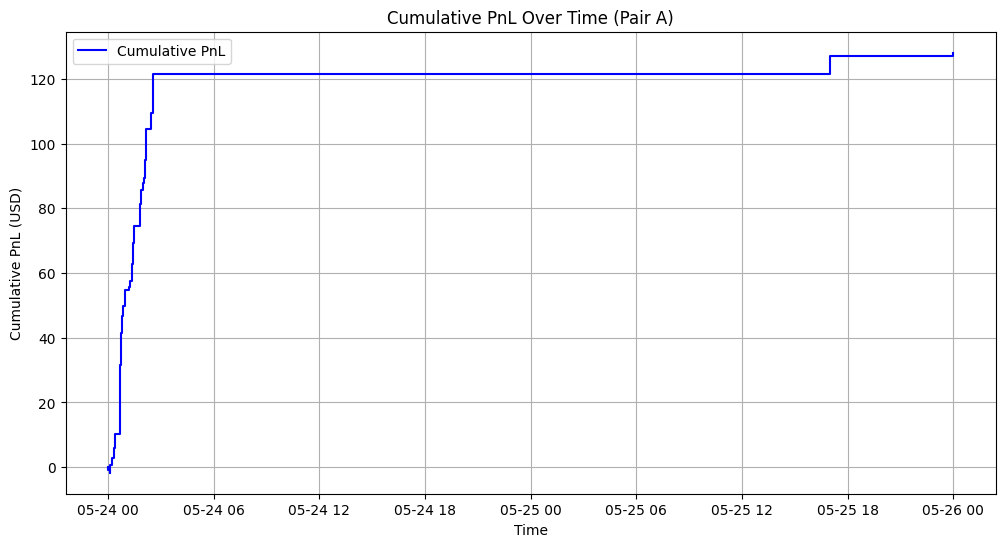

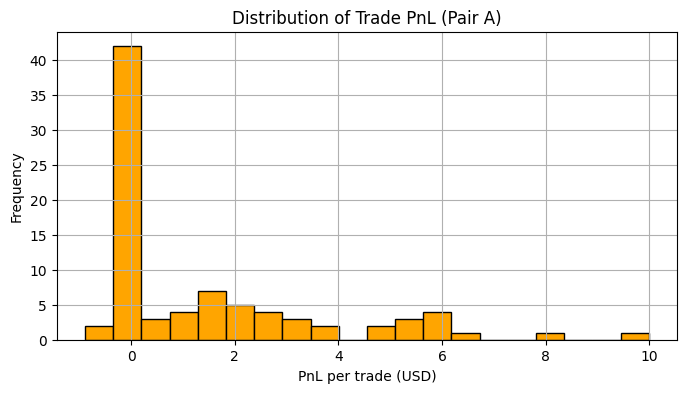

--- Pair B ---
Number of trades: 7
Raw return: $41.10
Max drawdown: $0.00
Sharpe ratio (per trade): 3.47




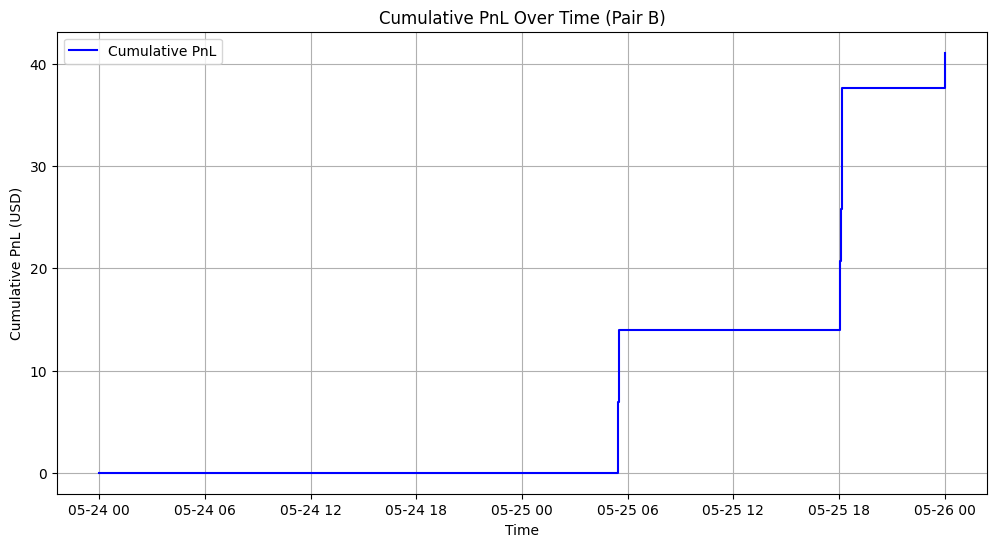

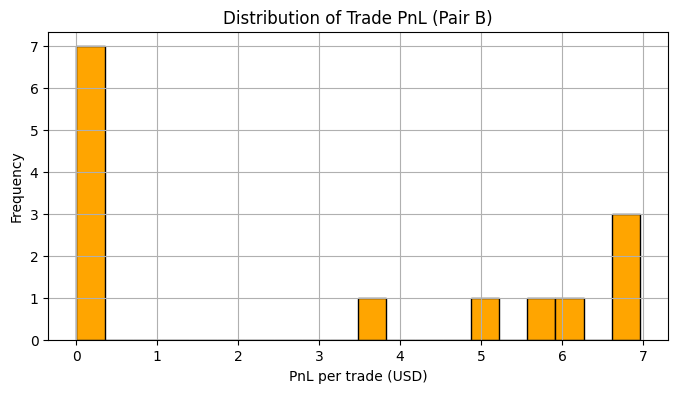

--- Pair C ---
Number of trades: 166
Raw return: $759.33
Max drawdown: $1.22
Sharpe ratio (per trade): 14.24




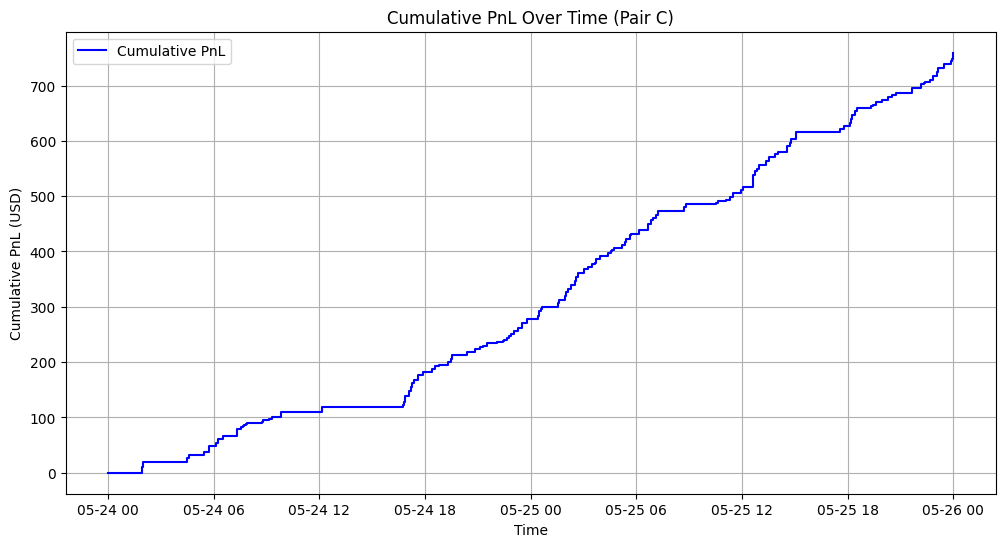

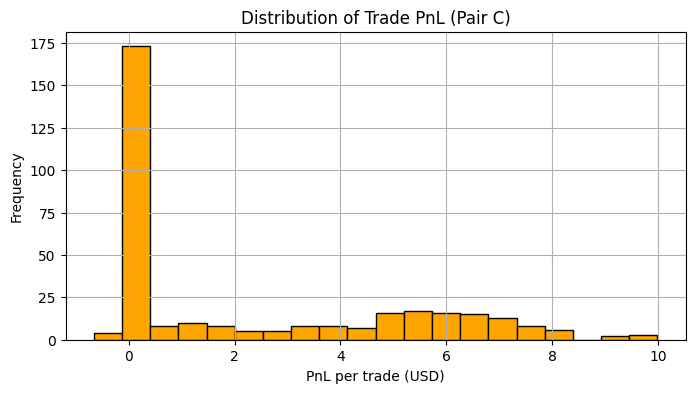

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_trades(trades_df, starting_capital=80000.0, name="Trade"):
    if trades_df.empty:
        print(f"No trades to analyze for {name}.")
        return

    trades_df = trades_df.copy()
    trades_df['cumulative_pnl'] = trades_df['capital'] - starting_capital
    trades_df['returns'] = trades_df['cumulative_pnl'].diff().fillna(0)

    mean_return = trades_df['returns'].mean()
    std_return = trades_df['returns'].std()
    sharpe = (mean_return / std_return * np.sqrt(len(trades_df))) if std_return != 0 else np.nan

    cum_max = trades_df['capital'].cummax()
    drawdown = trades_df['capital'] - cum_max
    max_drawdown = drawdown.min()

    raw_return = trades_df['capital'].iloc[-1] - starting_capital

    print(f"--- {name} ---")
    print(f"Number of trades: {len(trades_df)//2}")
    print(f"Raw return: ${raw_return:,.2f}")
    print(f"Max drawdown: ${abs(max_drawdown):,.2f}")
    print(f"Sharpe ratio (per trade): {sharpe:.2f}")
    print("\n")

    plt.figure(figsize=(12,6))
    plt.step(trades_df['ts_1s'], trades_df['cumulative_pnl'], where='post', color='blue', label='Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL (USD)')
    plt.title(f'Cumulative PnL Over Time ({name})')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.hist(trades_df['returns'], bins=20, color='orange', edgecolor='black')
    plt.xlabel('PnL per trade (USD)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Trade PnL ({name})')
    plt.grid(True)
    plt.show()

for name, trades_df in all_trades.items():
    analyze_trades(trades_df, starting_capital=80000.0, name=f"Pair {name}")

In [116]:
summary_data = []

for name, trades_df in all_trades.items():
    if trades_df.empty:
        summary_data.append([name, 0, np.nan, np.nan])
        continue

    trades_df = trades_df.copy()
    trades_df['cumulative_pnl'] = trades_df['capital'] - 80000
    trades_df['returns'] = trades_df['cumulative_pnl'].diff().fillna(0)

    mean_return = trades_df['returns'].mean()
    std_return = trades_df['returns'].std()
    sharpe = (mean_return / std_return * np.sqrt(len(trades_df))) if std_return != 0 else np.nan

    cum_max = trades_df['capital'].cummax()
    drawdown = trades_df['capital'] - cum_max
    max_drawdown = drawdown.min()

    raw_return = trades_df['capital'].iloc[-1] - 80000

    summary_data.append([name, raw_return, sharpe, abs(max_drawdown)])

summary_df = pd.DataFrame(summary_data, columns=['Pair', 'Raw Return ($)', 'Sharpe Ratio', 'Max Drawdown ($)'])
summary_df = summary_df.sort_values('Raw Return ($)', ascending=False).reset_index(drop=True)

print("Summary of Trading Performance:\n")
print(summary_df)

Summary of Trading Performance:

  Pair  Raw Return ($)  Sharpe Ratio  Max Drawdown ($)
0    C      752.253034     14.238468          1.226897
1    A      126.693498      6.190826          1.728202
2    B       40.689722      3.470556          0.000000


The choice of g = 1.5 and j = 0.5, along with N = M = 10, was guided by guess-and-check experimentation aimed at finding reasonably good inputs that optimize PnL. Specifically, g was selected to identify sufficiently large deviations in the spreads to enter trades with high probability of profit, while j was chosen to exit trades before adverse movements could erase gains. The rolling window M and rank N were set to 10 to capture persistent small/large values in the spread without being too sensitive to short-term noise. These values were not the result of exhaustive optimization but rather simple heuristics that balanced responsiveness to spread movements with stability, producing strong PnL performance across all three pairs.

Trading Strategy Summary

The results shown above use the best input parameters I could identify to maximize PnL. As discussed in class, PnL scales linearly with trade size, so the trade size was kept constant at 1 for these experiments.

The parameters experimented with include:

g (entry threshold)

j (exit threshold)

N (rank for persistent small/large calculation)

M (rolling window for persistence)

Fee size (per trade cost)

From the analysis, the spreads occasionally widened significantly, creating clear opportunities for profit even after accounting for trade fees of 1%. This explains the large Sharpe ratios and minimal drawdowns observed across the three spreads.

To prevent unrealistic extreme values after the EMA adjustment, a cap was applied to the shifted spreads, keeping the signals more reasonable.

In practice, however, fees, slippage, and operational challenges when trading across crypto exchanges would likely make implementing this spread trading strategy profitably much more difficult than suggested by this backtest.